In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.ion()

In [3]:
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles


outline = gpd.read_file('Iceland/ISL_adm0.shp').to_crs(32626)

In [4]:
roads = gpd.read_file('Iceland/roads.shp').to_crs(32626)
rivers = gpd.read_file('Iceland/waterways.shp').to_crs(32626)
points = gpd.read_file('Iceland/points.shp').to_crs(32626)
counties = gpd.read_file ('Iceland/ISL_adm1.shp').to_crs(32626)
population = gpd.read_file('Iceland/population.shp').to_crs(32626)

<IPython.core.display.Javascript object>


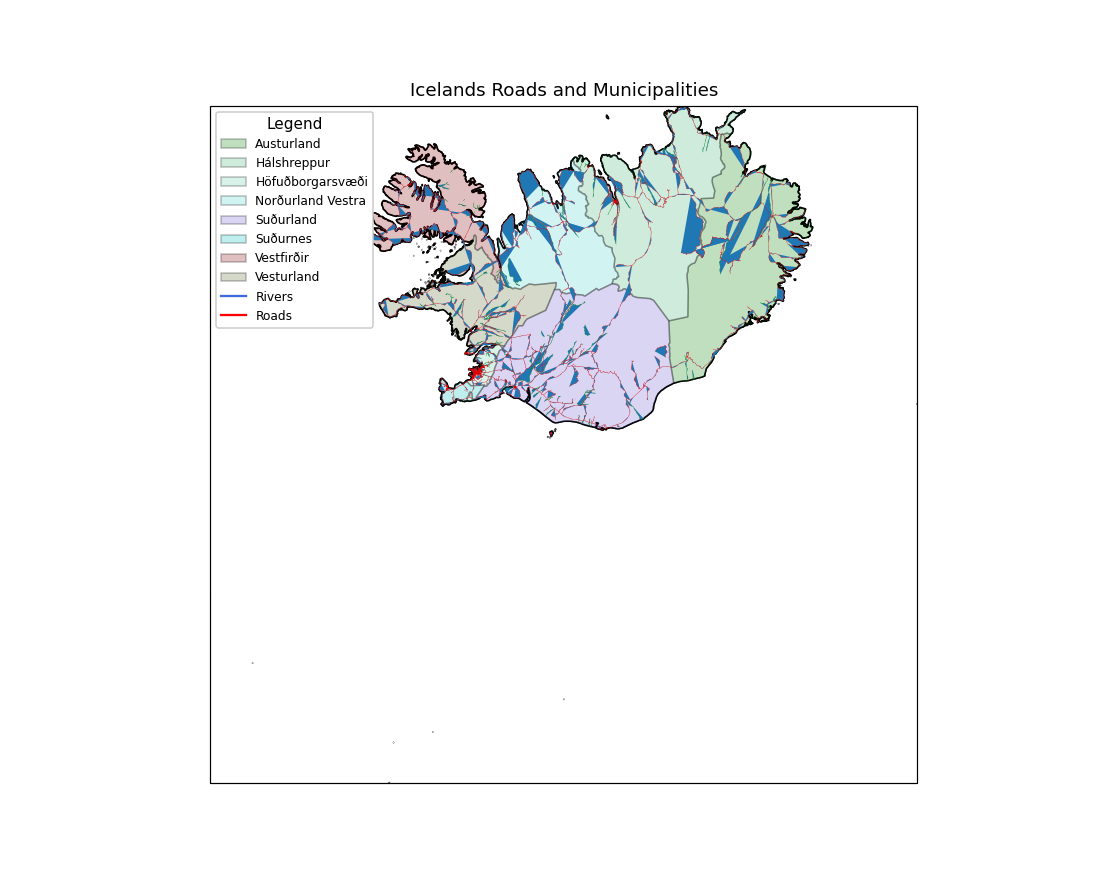

<IPython.core.display.Javascript object>


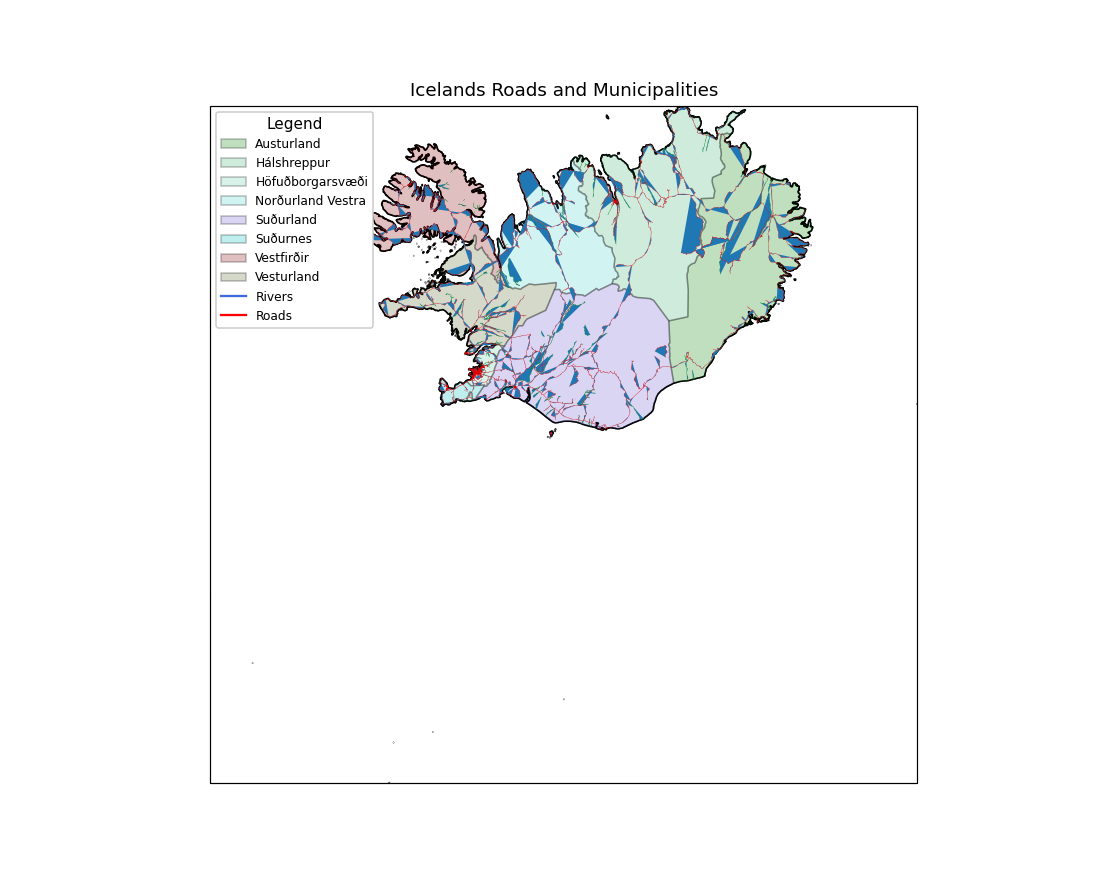

In [5]:
myFig = plt.figure(figsize=(10,8))

myCRS = ccrs.UTM(26)  

ax = plt.axes(projection=ccrs.UTM(26))

myFig

<IPython.core.display.Javascript object>


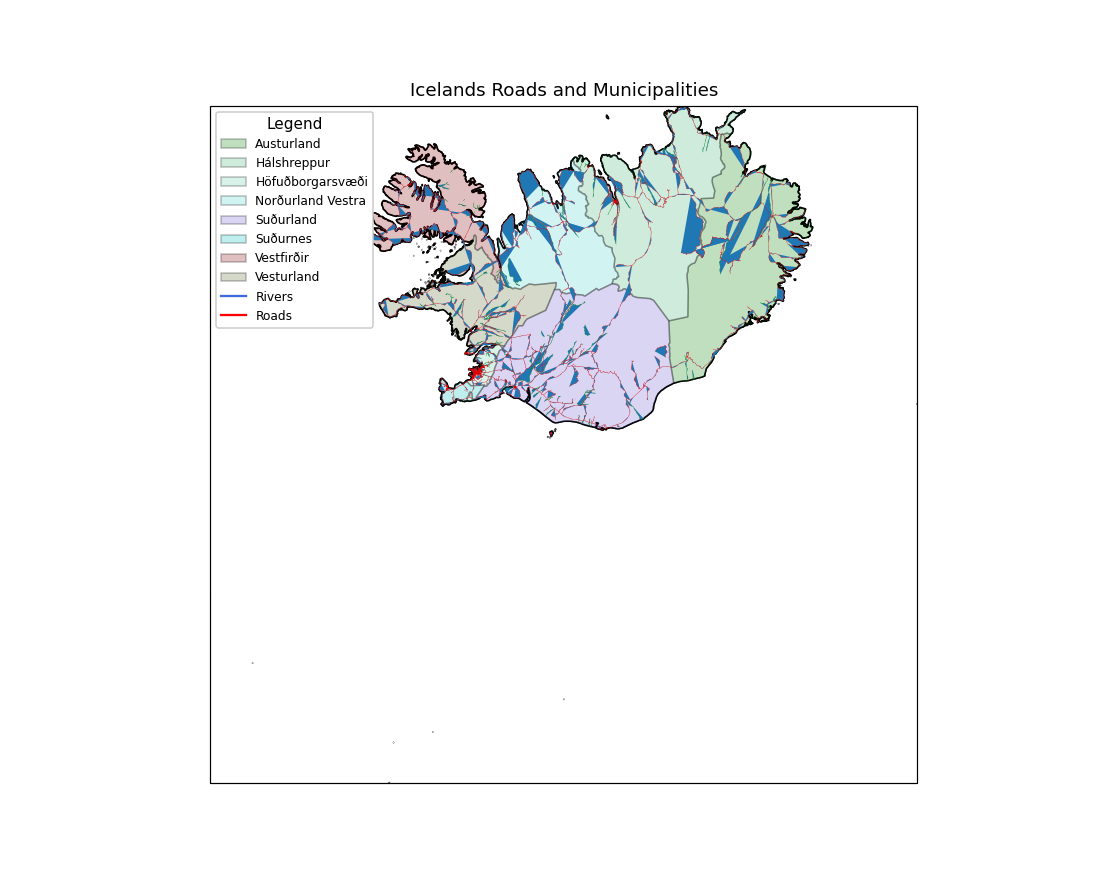

In [6]:
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature)

ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS) 

myFig

In [7]:
num_counties = len(counties.NAME_1.unique())
print('Number of unique features: {}'.format(num_counties))

Number of unique features: 8


In [8]:
df = pd.read_csv('Iceland\ISL_adm1.csv')
df.head()
df

,OBJECTID,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1
0,1,104,ISL,Iceland,1,Austurland,Landsvæði,Region,NaN,Eastland
1,2,104,ISL,Iceland,2,Hálshreppur,Landsvæði,Region,NaN,Norðurland eystra|Northland East
2,3,104,ISL,Iceland,3,Höfuðborgarsvæði,Landsvæði,Region,NaN,Capital|Reykjavik and Reykjane
3,4,104,ISL,Iceland,4,Norðurland vestra,Landsvæði,Region,NaN,Northland West
4,5,104,ISL,Iceland,5,Suðurland,Landsvæði,Region,NaN,Southland|South
5,6,104,ISL,Iceland,6,Suðurnes,Kaupstadir,Independent Town,NaN,Southern Peninsula
6,7,104,ISL,Iceland,7,Vestfirðir,Landsvæði,Region,NaN,Western Fjords|Western Peninsula
7,8,104,ISL,Iceland,8,Vesturland,Landsvæði,Region,NaN,Westland|West


<IPython.core.display.Javascript object>


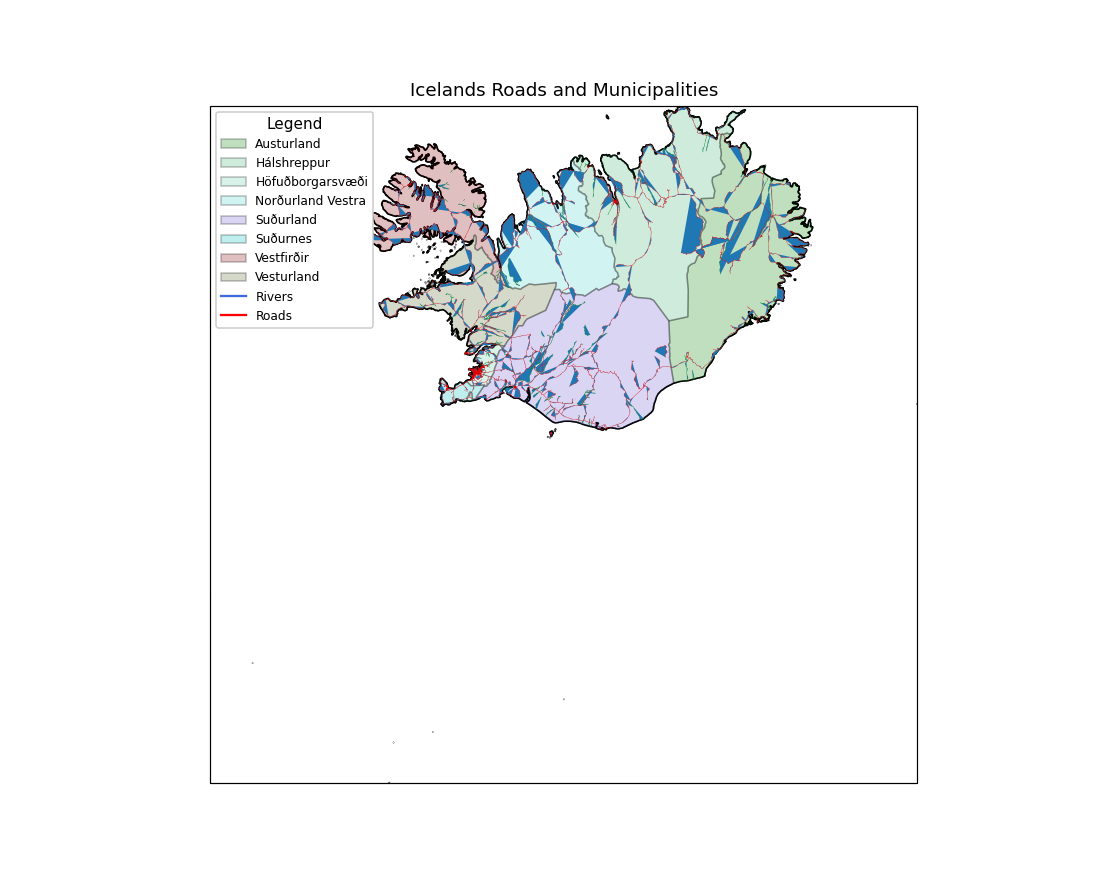

In [9]:
county_colors = ['g','mediumseagreen','mediumaquamarine','mediumturquoise','slateblue','c','maroon','darkolivegreen']

county_names = list(counties.NAME_1.unique())
county_names.sort()

for i, name in enumerate(county_names):
    feat = ShapelyFeature(counties['geometry'][counties['NAME_1'] == name], myCRS, 
                          edgecolor='k',
                          facecolor=county_colors[i],
                          linewidth=1,
                          alpha=0.25)
    ax.add_feature(feat)
    
myFig


<IPython.core.display.Javascript object>


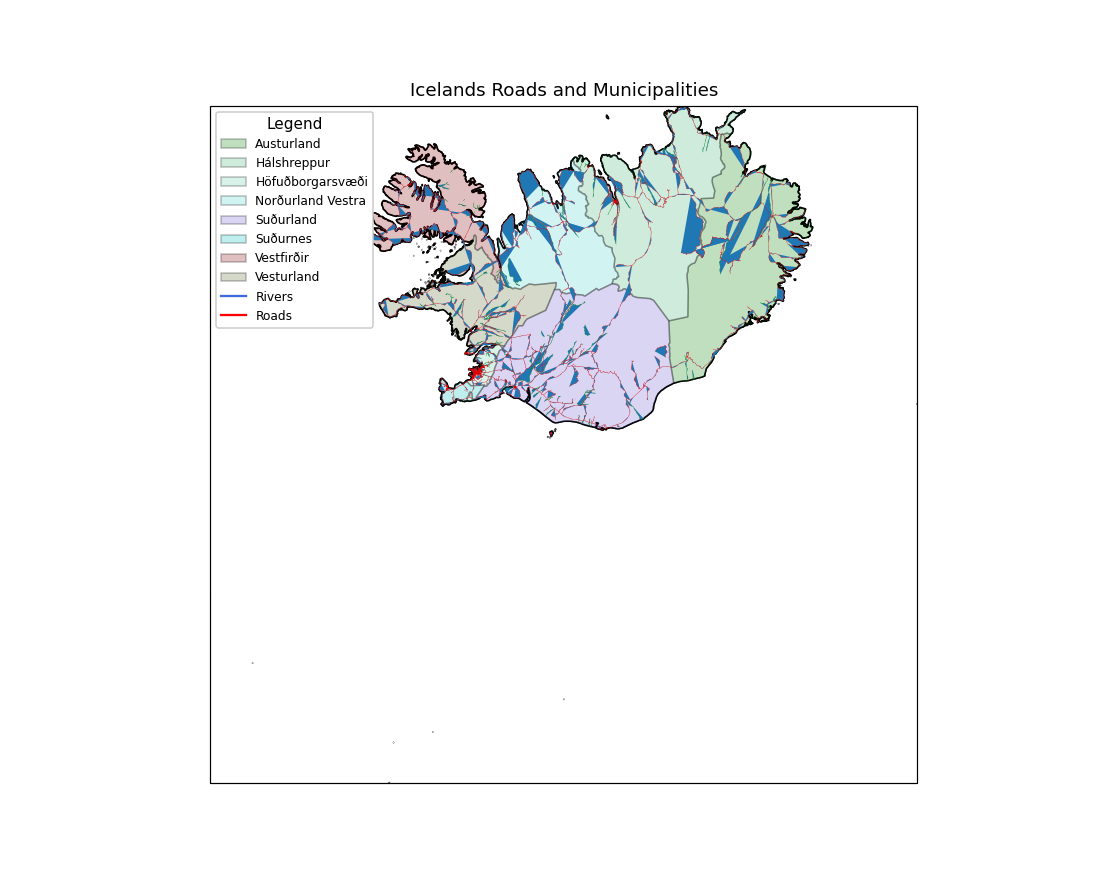

In [10]:
river_feat = ShapelyFeature(rivers['geometry'], myCRS,
                            edgecolor='green',
                            linewidth=0.2)
ax.add_feature(river_feat)
roads_feat= ShapelyFeature(roads['geometry'], myCRS,
                            edgecolor='red',
                             linewidth=0.2)

ax.add_feature(roads_feat)

myFig

<IPython.core.display.Javascript object>


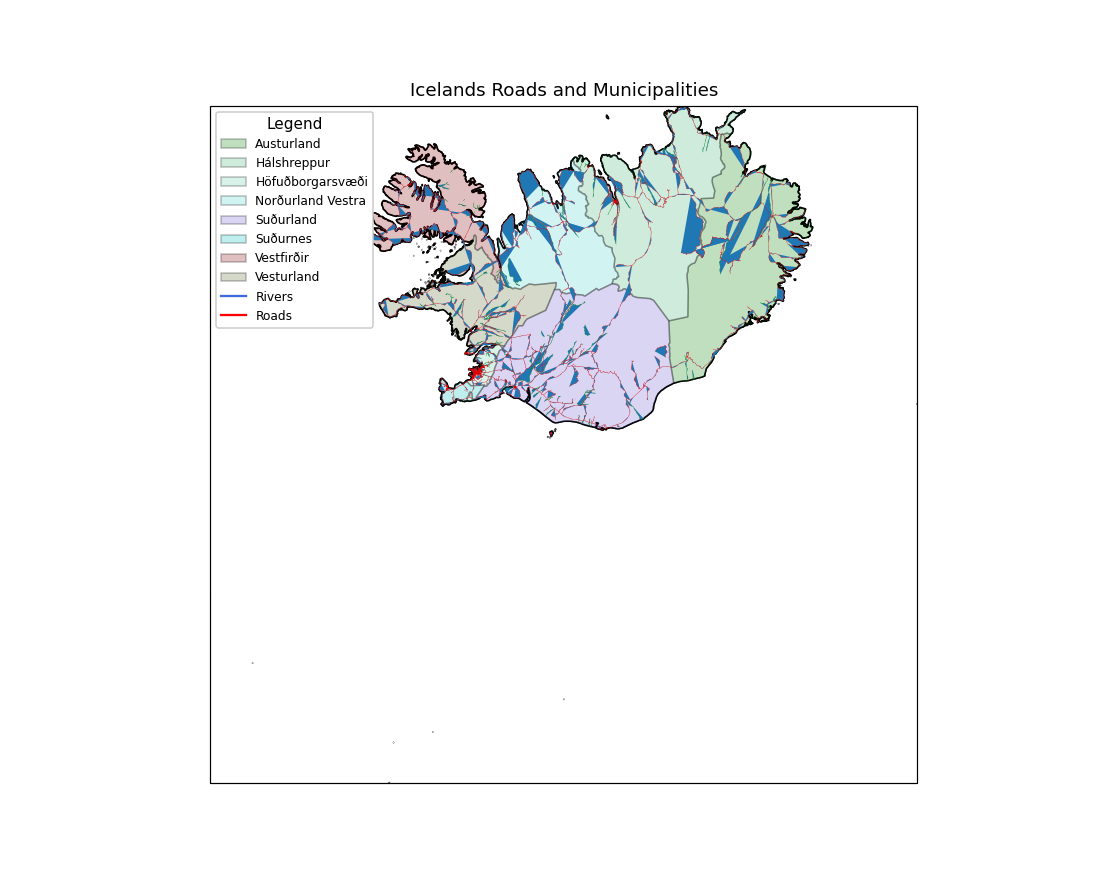

In [11]:
# generate a list of handles for the county datasets
county_handles = generate_handles(counties.NAME_1.unique(), county_colors, alpha=0.25)

# note: if you change the color you use to display rivers, you'll want to change it here, too
river_handle = [mlines.Line2D([], [], color='royalblue')]

roads_handle = [mlines.Line2D([],[], color='red')]

# update county_names to take it out of uppercase text
nice_names = [name.title() for name in county_names]

# ax.legend() takes a list of handles and a list of labels corresponding to the objects you want to add to the legend
handles = county_handles + river_handle + roads_handle
labels = nice_names + ['Rivers', 'Roads']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=10, 
                 fontsize=8, loc='upper left', frameon=True, framealpha=1)
ax.set(title='Icelands Roads and Municipalities')

myFig

In [12]:
df = gpd.read_file('Iceland\waterways.shp').to_crs(32626)
df.head()
df

,osm_id,name,type,width,geometry
0,5042693,HrosshÃ³lmalÃ¦kur,stream,0,"LINESTRING (943634.594 7097930.031, 943639.675..."
1,5042702,RauÃ°Ã¡,stream,0,"LINESTRING (938686.533 7102932.591, 938696.027..."
2,5782599,SogiÃ°,river,0,"LINESTRING (790355.841 7125485.668, 790400.716..."
3,8079753,GÃ­gjukvÃ­sl,river,0,"LINESTRING (970618.356 7125625.124, 970694.144..."
4,8079754,GÃ­gjukvÃ­sl,river,0,"LINESTRING (970904.793 7125621.905, 970955.812..."
...,...,...,...,...,...
271,34327968,None,stream,0,"LINESTRING (747275.126 7144130.507, 747331.204..."
272,37017981,None,stream,0,"LINESTRING (867037.079 7071199.511, 866968.826..."
273,37017982,None,stream,0,"LINESTRING (865660.730 7071803.390, 865733.825..."
274,37017983,None,stream,0,"LINESTRING (866300.511 7071843.333, 866267.722..."


In [13]:
counties = gpd.read_file ('Iceland/ISL_adm1.shp').to_crs(32626)



In [14]:
#check that both datatsets are going to work in a join with the CRS
rivers.crs
counties.crs

<Projected CRS: EPSG:32626>
Name: WGS 84 / UTM zone 26N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°W and 24°W, northern hemisphere between equator and 84°N, onshore and offshore. Greenland. Iceland.
- bounds: (-30.0, 0.0, -24.0, 84.0)
Coordinate Operation:
- name: UTM zone 26N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
#As its a large file, want to focus on just one element of interest type. In this case attractions!
rivers[rivers['type'] == 'river']

,osm_id,name,type,width,geometry
2,5782599,SogiÃ°,river,0,"LINESTRING (790355.841 7125485.668, 790400.716..."
3,8079753,GÃ­gjukvÃ­sl,river,0,"LINESTRING (970618.356 7125625.124, 970694.144..."
4,8079754,GÃ­gjukvÃ­sl,river,0,"LINESTRING (970904.793 7125621.905, 970955.812..."
5,8079819,NÃºpsvÃ¶tn,river,0,"LINESTRING (966175.157 7127357.912, 966159.096..."
6,8079820,NÃºpsvÃ¶tn,river,0,"LINESTRING (965585.588 7127196.526, 965609.853..."
...,...,...,...,...,...
260,33178754,None,river,0,"LINESTRING (1088821.796 7244248.199, 1089069.6..."
261,33179956,None,river,0,"LINESTRING (761261.080 7128516.935, 761149.871..."
262,33179962,None,river,0,"LINESTRING (760913.827 7128561.301, 760807.594..."
265,33608896,AndakÃ­lsÃ¡,river,0,"LINESTRING (758023.424 7168059.587, 757908.341..."


In [16]:
for i, row in rivers.iterrows(): 
    rivers.loc[i, 'Length'] = row['geometry'].length 
    
print(rivers.head()) 

    osm_id               name    type  width  \
0  5042693  HrosshÃ³lmalÃ¦kur  stream      0   
1  5042702            RauÃ°Ã¡  stream      0   
2  5782599             SogiÃ°   river      0   
3  8079753       GÃ­gjukvÃ­sl   river      0   
4  8079754       GÃ­gjukvÃ­sl   river      0   

                                            geometry        Length  
0  LINESTRING (943634.594 7097930.031, 943639.675...    215.427916  
1  LINESTRING (938686.533 7102932.591, 938696.027...    232.027837  
2  LINESTRING (790355.841 7125485.668, 790400.716...  11500.939822  
3  LINESTRING (970618.356 7125625.124, 970694.144...   1030.094214  
4  LINESTRING (970904.793 7125621.905, 970955.812...    960.367944  


In [17]:
sum_rivers = rivers['Length'].sum()
sum_mainrivers = rivers[rivers['type'] == 'river']['Length'].sum()
print('{:.2f} total m of rivers'.format(sum_rivers))
print('{:.2f} total m of mainrivers'.format(sum_mainrivers))


2565046.01 total m of rivers
2377823.28 total m of mainrivers


In [18]:
rivers.groupby(['type'])['Length'].sum() / 1000 

type
dam          1.378657
dock         0.388167
drain        2.205262
river     2377.823285
stream     183.250636
Name: Length, dtype: float64

In [19]:
join = gpd.sjoin(counties, rivers, how='inner', lsuffix='left', rsuffix='right')
join # show the joined table

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,index_right,osm_id,name,type,width,Length
0,104,ISL,Iceland,1,Austurland,Landsvæði,Region,None,Eastland,"MULTIPOLYGON (((1249450.486 7084137.776, 12493...",80,26099211,ÃssurÃ¡,river,0,5981.104210
0,104,ISL,Iceland,1,Austurland,Landsvæði,Region,None,Eastland,"MULTIPOLYGON (((1249450.486 7084137.776, 12493...",82,26099249,HvaldalsÃ¡,river,0,5259.206828
0,104,ISL,Iceland,1,Austurland,Landsvæði,Region,None,Eastland,"MULTIPOLYGON (((1249450.486 7084137.776, 12493...",111,26386100,None,river,0,112.702217
0,104,ISL,Iceland,1,Austurland,Landsvæði,Region,None,Eastland,"MULTIPOLYGON (((1249450.486 7084137.776, 12493...",258,33178750,None,river,0,994.821385
0,104,ISL,Iceland,1,Austurland,Landsvæði,Region,None,Eastland,"MULTIPOLYGON (((1249450.486 7084137.776, 12493...",260,33178754,None,river,0,1020.410402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,104,ISL,Iceland,8,Vesturland,Landsvæði,Region,None,Westland|West,"MULTIPOLYGON (((737217.226 7140594.338, 737146...",156,28085067,None,river,0,1294.019284
7,104,ISL,Iceland,8,Vesturland,Landsvæði,Region,None,Westland|West,"MULTIPOLYGON (((737217.226 7140594.338, 737146...",159,28085072,None,river,0,17329.354668
7,104,ISL,Iceland,8,Vesturland,Landsvæði,Region,None,Westland|West,"MULTIPOLYGON (((737217.226 7140594.338, 737146...",158,28085071,None,river,0,2172.910488
7,104,ISL,Iceland,8,Vesturland,Landsvæði,Region,None,Westland|West,"MULTIPOLYGON (((737217.226 7140594.338, 737146...",157,28085069,None,river,0,6968.342070


In [20]:
join_total = join['Length'].sum()
print(join.groupby(['NAME_1', 'type'])['Length'].sum() / 1000) 

print(sum_rivers)
print(join_total)

NAME_1             type  
Austurland         dam         1.257705
                   river     382.872230
                   stream      5.277124
Hálshreppur        river     383.126355
Höfuðborgarsvæði   dam         0.120952
                   dock        0.388167
                   drain       0.067000
                   river      79.479336
                   stream     25.174012
Norðurland vestra  river     329.110175
Suðurland          river     784.626663
                   stream     72.229555
Vestfirðir         river     162.888847
                   stream     45.923226
Vesturland         river     371.748740
                   stream     34.646718
Name: Length, dtype: float64
2565046.0061504706
2678936.806115739


In [21]:
clipped = [] 
for county in counties['NAME_1'].unique():
    tmp_clip = gpd.clip(rivers, counties[counties['NAME_1'] == county]) 
    for i, row in tmp_clip.iterrows():
        tmp_clip.loc[i, 'type'] = row['geometry'].length 
        tmp_clip.loc[i, 'NAME_1'] = county 
    clipped.append(tmp_clip) 


clipped_gdf = gpd.GeoDataFrame(pd.concat(clipped))
clip_total = clipped_gdf['Length'].sum()


print(clip_total) 

2678936.806115739


In [38]:
#clipped_gdf[clipped_gdf['type'] == 'river'].groupby('NAME_1').sum()
#df# need to write summary on clipped data ... export chart?...
clipped_gdf.groupby('type')['river'].sum()

KeyError: 'Column not found: river'

In [28]:
#second section--------------------------------------------------------------------

In [23]:
counties.crs

<Projected CRS: EPSG:32626>
Name: WGS 84 / UTM zone 26N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°W and 24°W, northern hemisphere between equator and 84°N, onshore and offshore. Greenland. Iceland.
- bounds: (-30.0, 0.0, -24.0, 84.0)
Coordinate Operation:
- name: UTM zone 26N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<IPython.core.display.Javascript object>


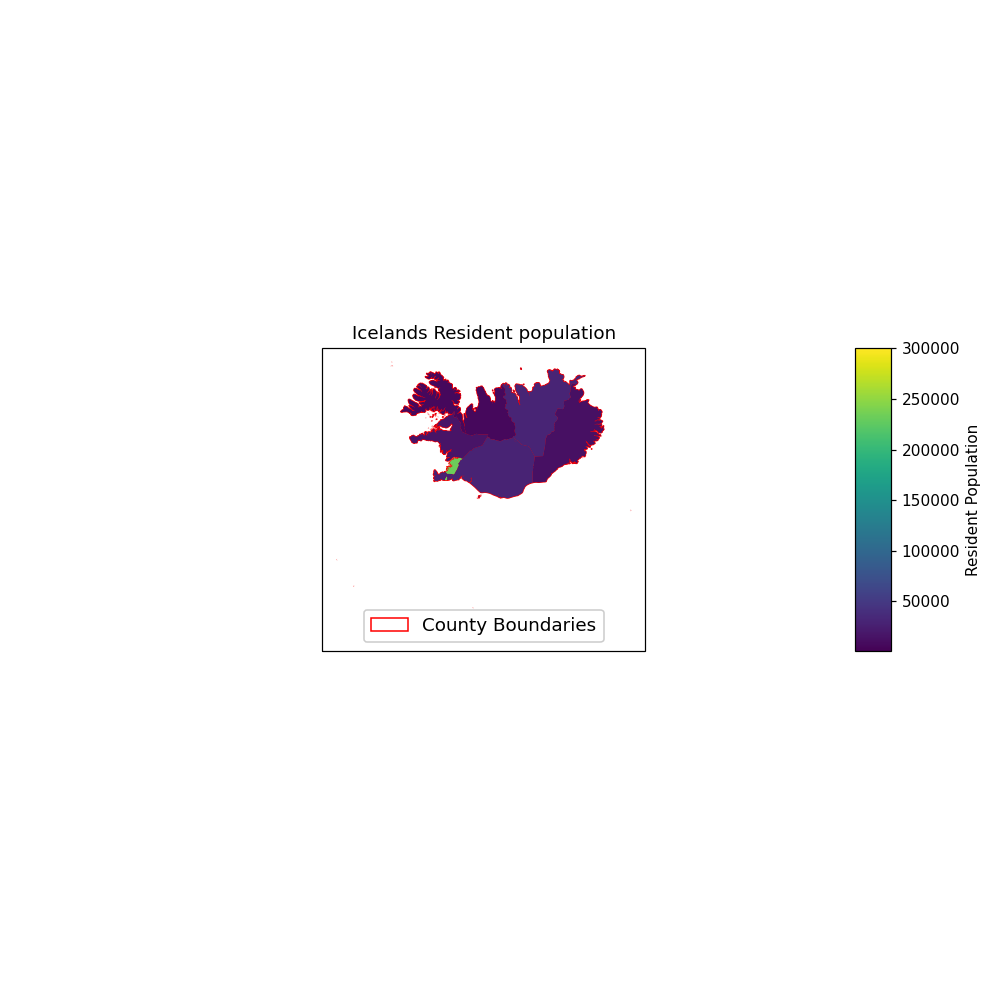

<IPython.core.display.Javascript object>


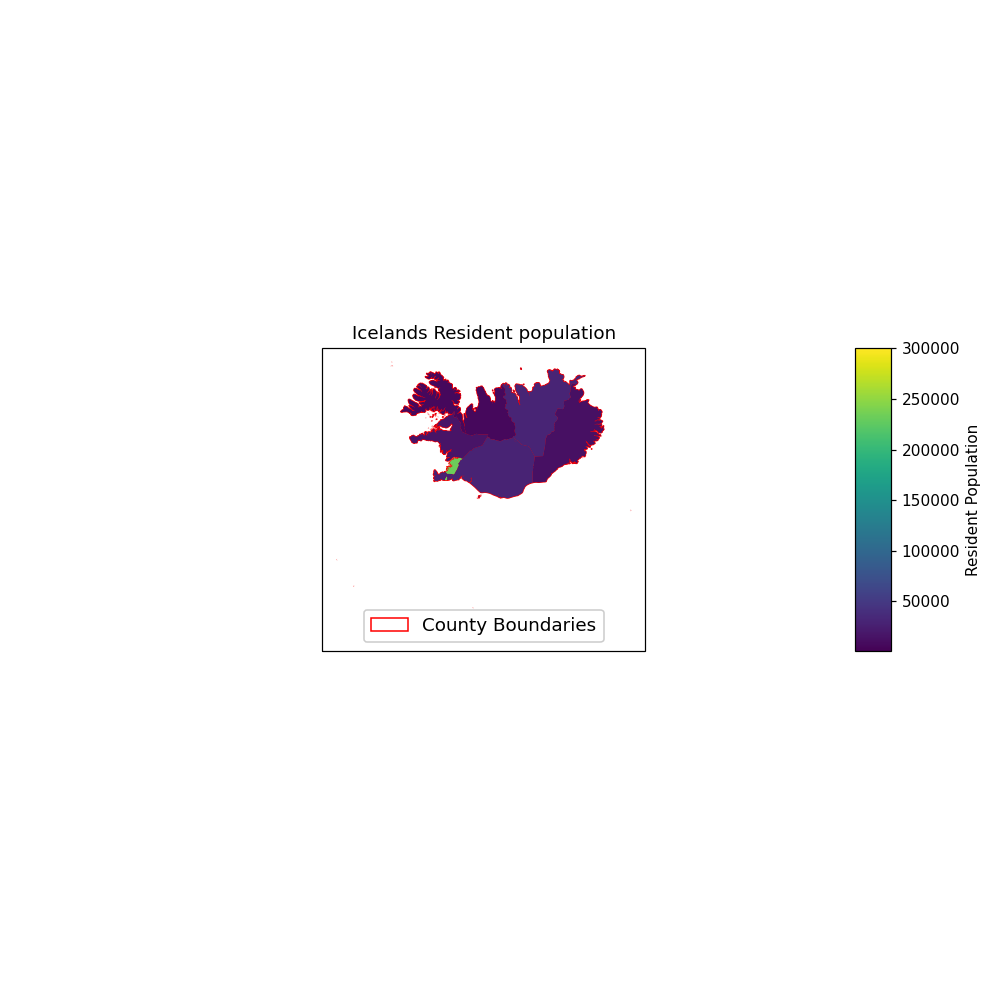

In [24]:
plt.figure(1)
myFig2 = plt.figure(figsize=(9, 9)) 

myCRS = ccrs.UTM(26)  

ax = plt.axes(projection=ccrs.Mercator()) 

myFig2

In [25]:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

In [26]:
population = gpd.read_file('Iceland/population.shp')
print(population)

   ID_0  ISO   NAME_0  ID_1             NAME_1      TYPE_1         ENGTYPE_1  \
0   104  ISL  Iceland     1         Austurland   Landsvæði            Region   
1   104  ISL  Iceland     2        Hálshreppur   Landsvæði            Region   
2   104  ISL  Iceland     3   Höfuðborgarsvæði   Landsvæði            Region   
3   104  ISL  Iceland     4  Norðurland vestra   Landsvæði            Region   
4   104  ISL  Iceland     5          Suðurland   Landsvæði            Region   
5   104  ISL  Iceland     6           Suðurnes  Kaupstadir  Independent Town   
6   104  ISL  Iceland     7         Vestfirðir   Landsvæði            Region   
7   104  ISL  Iceland     8         Vesturland   Landsvæði            Region   

  NL_NAME_1                         VARNAME_1  Number           English_na  \
0      None                          Eastland       7       Eastern Region   
1      None  Norðurland eystra|Northland East       6  Northeastern Region   
2      None    Capital|Reykjavik and Reykjane

<IPython.core.display.Javascript object>


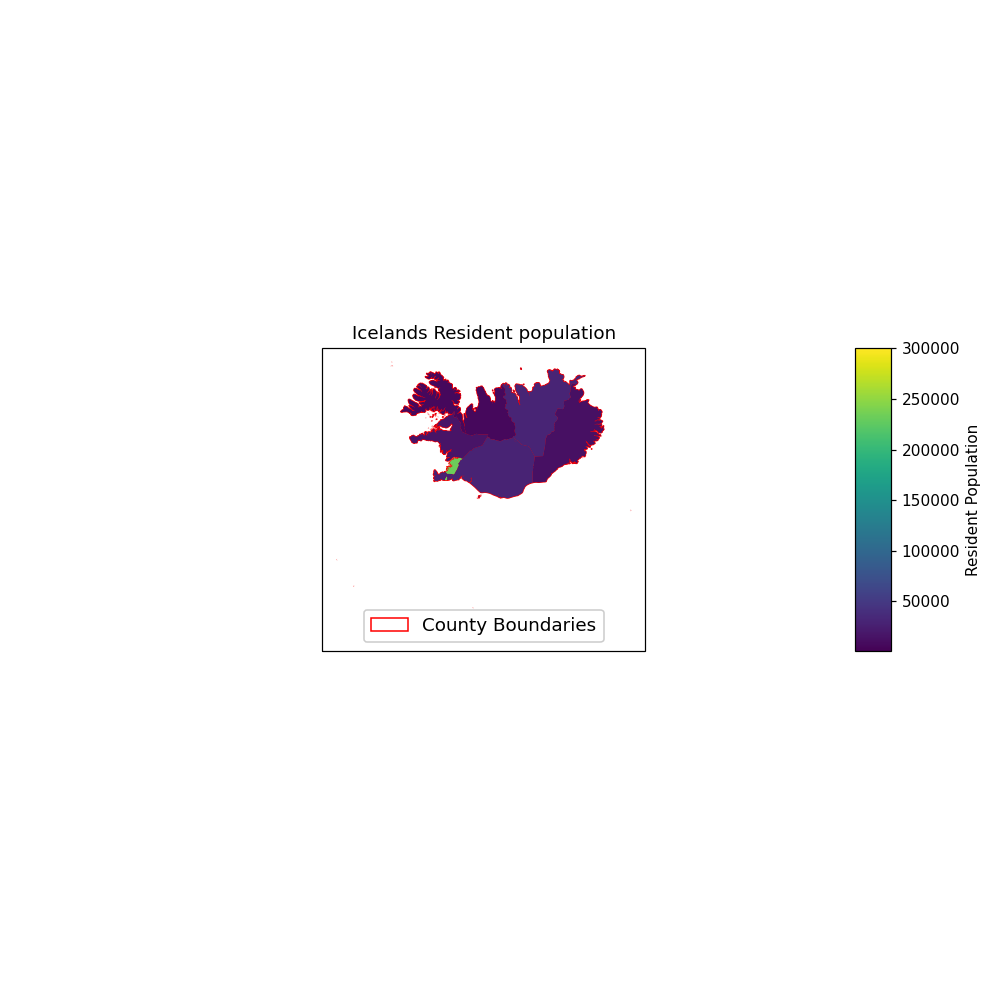

In [27]:
population_plot=population.plot(column='Population', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='r')

population_plot = population.plot(column='Population', ax=ax, vmin=300, vmax=300000, cmap='viridis',
                      legend=True, cax=cax, legend_kwds={'label': 'Resident Population'})

population_outlines = ShapelyFeature(population['geometry'], myCRS, edgecolor='r', facecolor='none')

ax.add_feature(population_outlines)
population_handles = generate_handles([''], ['none'], edge='r')

ax.set(title='Icelands Resident population')
ax.legend(population_handles, ['County Boundaries'], fontsize=12, loc='lower center', framealpha=1)

myFig2

In [ ]:


#----------------------------------------------------------------------------------------